In [1]:
from math import log
import numpy as np
import operator
import matplotlib.pyplot as plt

In [2]:
# 计算 信息增益
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    #the the number of unique elements and their occurance
    # 计数，给每个不同的值计算出现的次数，并用这个次数计算器出现的概率
    for featVec in dataSet: 
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        #  log(prob,2) 可以视为 编码长度
        shannonEnt -= prob * log(prob,2) #log base 2
    return shannonEnt

In [30]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    #change to discrete values
    return dataSet, labels

In [31]:
myDat, labels = createDataSet()
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [5]:
calcShannonEnt(myDat)

0.9709505944546686

In [13]:
# 基尼不纯度样例
def giniImpurity(rows):
    total = len(rows)
    #print(total)
    # 计算每一行数据的可能数量
    counts = {}
    for row in rows:
        # 对最后一列的值计算
        #r = row[len(row) - 1]
        # 对倒数第三的值计算，也就是yes 和no 的一列
        r = row[-1]
        if r not in counts.keys(): 
            counts[r] = 0
        counts[r] += 1
    #print(counts)
    imp = 0
    for k1 in counts:
        p1 = float(counts[k1]) / total
        #print(counts[k1])
        for k2 in counts:
            if k1 == k2: continue
            p2 = float(counts[k2]) / total
            imp += p1 * p2
    return imp

In [14]:
giniImpurity(myDat)

0.48

In [15]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     #chop out axis used for splitting
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [20]:
onePiece = splitDataSet(myDat,1,1)
onePiece = splitDataSet(onePiece,0,1)
onePiece

[['yes'], ['yes']]

In [23]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1      #the last column is used for the labels
    # 计算分组前的信息熵
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):        #iterate over all the features
        featList = [example[i] for example in dataSet]#create a list of all the examples of this feature
        uniqueVals = set(featList)       #get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            # 获取某个属性 子集，
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            # 计算每个分支的信息熵， 乘上它对应的概率 
            newEntropy += prob * calcShannonEnt(subDataSet)     
        infoGain = baseEntropy - newEntropy     #calculate the info gain; ie reduction in entropy
        if (infoGain > bestInfoGain):       #compare this to the best gain so far
            bestInfoGain = infoGain         #if better than current best, set to best
            bestFeature = i
    return bestFeature                      #returns an integer

In [24]:
bestFeature = chooseBestFeatureToSplit(myDat)
bestFeature

0

In [26]:
# 给终结节点打上类别标记
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): 
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

In [39]:
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    # 判断是否全部为 同一个类别
    if classList.count(classList[0]) == len(classList): 
        return classList[0]#stop splitting when all of the classes are equal
    # 所有属性都用完了
    if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = \
            createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree    

In [40]:
# 复制labels， createTree 会改变 abels 的值
myTree = createTree(myDat,labels[:])
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [35]:
labels

['no surfacing', 'flippers']

In [41]:
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

In [59]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [56]:
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )

In [57]:
def createPlotV1():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)    #no ticks
    plotNode('决策节点', (0.5,0.1), (0.1, 0.5),decisionNode)
    plotNode('叶节点', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

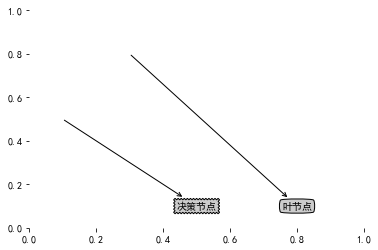

In [60]:
createPlotV1()

In [72]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        #test to see if the nodes are dictonaires, if not they are leaf nodes
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

In [73]:
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        #test to see if the nodes are dictonaires, if not they are leaf nodes
        if type(secondDict[key]).__name__=='dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

In [65]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

In [74]:
def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        #test to see if the nodes are dictonaires, if not they are leaf nodes   
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

In [84]:
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; 
    plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

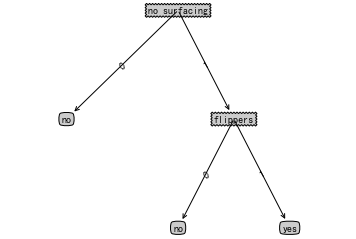

In [85]:
createPlot(myTree)

In [77]:
def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

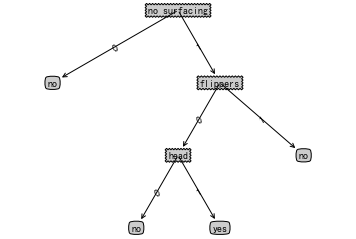

In [80]:
createPlot(retrieveTree(1))

In [81]:
def classify(inputTree,featLabels,testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict): 
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

In [88]:
classify(myTree, labels, [1,1])

'yes'

In [121]:
def storeTree(inputTree,filename):
    import pickle
    fw = open(filename,'wb')
    pickle.dump(inputTree, fw)
    fw.close()

In [122]:
storeTree(myTree, 'classifierStorage.txt')

In [123]:
def grabTree(filename):
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

In [124]:
storedTree = grabTree('classifierStorage.txt')
storedTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [126]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)
lensesTree

{'tearRate': {'reduced': 'no lenses',
  'normal': {'astigmatic': {'no': {'age': {'young': 'soft',
      'pre': 'soft',
      'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}}},
    'yes': {'prescript': {'myope': 'hard',
      'hyper': {'age': {'young': 'hard',
        'pre': 'no lenses',
        'presbyopic': 'no lenses'}}}}}}}}

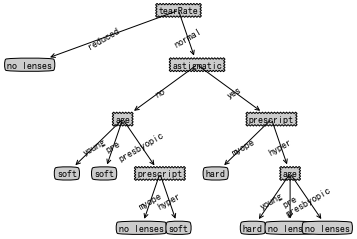

In [127]:
createPlot(lensesTree)